In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup

## Context

The objective of this notebook is to obtain through web scraping, a list of traditional Chilean recipes from a food blog, particularly "Mi Diario de Cocina" (https://www.midiariodecocina.com/recetas-chilenas/). Ideally this list should be obtained with all the elements that make up a recipe such as the name of the recipe, ingredients, steps, and other parameters of interest that we find. It would also be good to store it in a tabular format to have a more structured, consolidated format that allows the analysis and development of this dataset.

The resulting dataset can be found here: [Traditional Chilean Recipes](https://www.kaggle.com/datasets/francofaundez/traditional-chilean-recipes)

## Obtaining the recipes

- If we enter the website, we can see that all the recipes have a link that redirects the user to a page, where there is a description of the recipe. In this sense, what we could do would be to first get the list of all these links, and go through it to access each one of them individually.

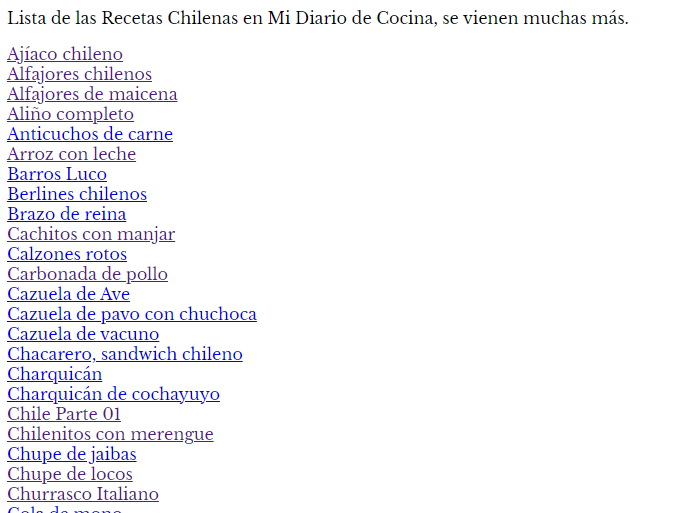

- Firstly, through BeautifulSoup we can access the webpage and then obtain the list of recipes in a few lines of code.

In [ ]:
url = 'https://www.midiariodecocina.com/recetas-chilenas/'

page = urlopen(url)
html = page.read().decode()
soup = BeautifulSoup(html, 'html.parser')

title_recipes = soup.find('p', string = 'Lista de las Recetas Chilenas en Mi Diario de Cocina, se vienen muchas más.')
recipes = title_recipes.find_next('p').find_all('a')

- If we check the list, we can see that not all of these links have a link associated to an external link. Most of them have a string with the index of the page to be accessed. This should not be a problem because we simply add this identifier to the original URL and we should be fine.

In [ ]:
recipes[:5]

## Iteration per recipe

- To obtain the information of a recipe, we can create a function that allows us to access the individual link previously obtained from the list of recipes.

- If we check the source code of the page, all the elements we are interested in are associated to a part of this code, which are:

    - Name of the recipe
    - Time of preparation
    - Yield (serving size in portions)
    - Ingredients
    - Instructions

- This function checks in each part of the recipe if the element in question exists. If it does not exist, it returns None and the recipe is skipped (in case no name is found) or NaN and the element is saved with that value (if it has no instructions, for example).

In [ ]:
def get_recipe_info(url_recipe):
    page_recipe = urlopen(url_recipe)
    html_recipe = page_recipe.read().decode()
    soup_recipe = BeautifulSoup(html_recipe, 'html.parser')

    # Titulo de la receta

    header_recipe = soup_recipe.find('header', attrs = {'class': 'tasty-recipes-entry-header'})
    
    if header_recipe is None:     
        return None

    # Name of the recipe
    name_class = header_recipe.find(attrs = {'class': 'tasty-recipes-title'})
    
    if name_class is not None:
        name_recipe = name_class.text
    else:        
        return None
    
    # Time of preparation
    time_class = header_recipe.find(attrs={'class': 'tasty-recipes-total-time'})
    
    if time_class is not None:
        total_time = time_class.text
    else:
        total_time = np.nan
 
    # Yield
    
    yield_class = header_recipe.find(attrs={'class': 'tasty-recipes-yield'})
    
    if yield_class is not None:
        recipe_yield = yield_class.text
    else:
        recipe_yield = np.nan

    # Ingredients
    li_ing = soup_recipe.find('div', attrs = {'class': 'tasty-recipes-ingredients'}).find_all('li')
    
    if len(li_ing) != 0:
        ingredients = []

        for li in li_ing:
            ingredients.append(li.text)
    else:
        ingredients = [np.nan]
        
    # Instructions
    li_instructions = soup_recipe.find('div', attrs = {'class':  'tasty-recipes-instructions'}).find_all('li')

    if len(li_instructions) != 0:
        instructions = []

        for e,li in enumerate(li_instructions):
            instructions.append(str(e+1) + '-' + li.text)
    else:
        instructions = [np.nan]
        
    recipe_info = [name_recipe,total_time,recipe_yield, ingredients,instructions]
    
    return recipe_info

- We iterate over the list with the recipes and apply the function.

In [ ]:
list_recipes = []
for recipe in recipes:
    link_receta = recipe['href']
    
    if '/?p=' in link_receta:
        link_receta = 'https://www.midiariodecocina.com' + link_receta
        
    print('Link de la receta: ' + link_receta)
        
    output_recipe = get_recipe_info(link_receta)
    
    if output_recipe is None:
        print('Este link no tiene una receta con un nombre')
        continue
    
    list_recipes.append(output_recipe)

- We want our list with a tabular format, so a pandas dataframe should do the work.

In [ ]:
df = pd.DataFrame(list_recipes, columns = ['recipe name', 'preparation time', 'yield', 'ingredients', 'steps'])

## Cleaning data

- It is necessary that the data comes clean and without errors, particularly we can do a very simple cleaning for 2 of the columns: preparation time and yield.

### Preparation time

- We can see that the time is defined in hours and/or minutes, but the word that defines the unit of time is not standarized (for the unit **minutes** we can see "min", "mins", "minutos", "m").

- We could standarize the unit of time in one column, keeping it in minutes.

In [ ]:
df['preparation time'].unique()

In [ ]:
prep_time_expanded = df['preparation time'].str.split(" ", expand = True)

- We can easily get the values of time through a split function, but we can see a particular case that we can just manually modify (since it's just one case).

In [ ]:
prep_time_expanded[0].unique()

In [ ]:
prep_time_expanded.loc[prep_time_expanded[0].notnull() & prep_time_expanded[0].str.contains(':')] = [120, 'min', 25, 'min']
prep_time_expanded = prep_time_expanded.astype({0: float, 2: float})

In [ ]:
prep_time_expanded[prep_time_expanded[0] > 0][1].unique()

- We take all of the hour values and then calculate the total minutes of each one. Then we sum it with the remanining minutes from the second column and we have the total preparation time.

In [ ]:
prep_time_expanded.loc[prep_time_expanded[1].isin(['hour', 'hours', 'horas']), 0] = prep_time_expanded.loc[prep_time_expanded[1].isin(['hour', 'hours', 'horas']), 0]*60
prep_time_expanded['total_time_min'] = (prep_time_expanded[0].fillna(0) + prep_time_expanded[2].fillna(0))

In [ ]:
df['preparation time min'] = prep_time_expanded['total_time_min']

In [ ]:
df

### Yield (portions)

- We can see a similar case for the yield. Based on the website, in some cases the servings per recipe have an approximation between two values, represented in this case with a "-". Also we can see that there is a '1x' which represents a multiplier of preparations for the recipe and calculates the total ingredients needed, but this gives us no extra information so we would like to drop it. 

In [ ]:
df['yield'].unique()

In [ ]:
yields = df['yield'].str.split(" ", expand = True)

In [ ]:
yields[1].unique()

In [ ]:
yields.loc[yields[1].isin(['unidades60', 'unidades'])]

- We filter the cases that have an extra string we don't want, and then we keep only the numbers of the minimum and maximum approximated serving size.

In [ ]:
correct_portions = yields[~yields[1].isin([np.nan, None])][0].str.split('-', expand = True).rename({0: 'min_portion', 1: 'max_portion'}, axis = 1)

In [ ]:
yields

- Finally, we save it in the original dataframe.

In [ ]:
yields = pd.concat([yields, correct_portions], axis = 1)

df[['min_portion', 'max_portion']] = yields[['min_portion', 'max_portion']]

df = df.drop(['preparation time', 'yield'], axis = 1)

In [ ]:
df = df[['recipe name', 'preparation time min', 'min_portion', 'max_portion', 'ingredients', 'steps']].rename({'preparation time min': 'preparation time'}, axis = 1)

In [ ]:
df.to_csv('chilean_recipes.csv', index = False)

In [ ]:
df.info()